In [1]:
%matplotlib inline
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

import numpy as np
import os
import pandas as pd
import random
import pickle
from tqdm import tqdm

import scipy
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier

from PIL import Image
import cv2

# os.environ["THEANO_FLAGS"] = "device=gpu,floatX=float32"
# import theano

os.environ["KERAS_BACKEND"] = "tensorflow"

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras import backend as K
K.set_image_dim_ordering('tf')

# Potential additions edge and line analysis can be combined with RGB statistics.
# Canny edge analysis and count how many 1s are there.
# Line edge analysis and count how many 1s are there.
# Corner analysis and count how many 1s are there.
# Modify RGB statistics to Purple, Blue, Green, Yellow, Red, Brown, White, Black?
# Check misclassification statistics
# Utilize an ensemble algorithm, so maybe a Random forest for color + edge statistics, and a separate
# like a CNN trained specifically to look for specific labels like blow down. This image feature algorithm
# may potentially use artificially generated data.

random_seed = 0
random.seed(random_seed)
np.random.seed(random_seed)

# Load data
folderpath = os.getcwd() + '/'
train_path = folderpath+'train-jpg/'
test_path = folderpath+'test-jpg/'
train = pd.read_csv(folderpath+'train.csv')
test = pd.read_csv(folderpath+'sample_submission_v2.csv')
imagesize = 128

def get_raw(df, data_path):
    im_features = df.copy()

    rgb = []
    for image_name in tqdm(im_features.image_name.values, mininterval=10): 
        img = Image.open(data_path + image_name + '.jpg')
        img = img.resize((imagesize,imagesize))
        img = np.array(img)[:,:,:3]
        # im = np.hstack( ( img[:,:,0].ravel(), img[:,:,1].ravel(), img[:,:,2].ravel() ))
        rgb.append( img )

    return np.array(rgb)

def getEdges(df, data_path):
    im_features = df.copy()

    edgeCountArr = []

    for image_name in tqdm(im_features.image_name.values, mininterval=10): 
        img = cv2.imread( data_path + image_name + '.jpg' , 0)
        img = cv2.resize(img, (imagesize, imagesize))
        edges = cv2.Canny( img, 5, 25)
        edgeCountArr.append( edges )
    
    return np.array(edgeCountArr)

def getEdgesCount(df, data_path):
    im_features = df.copy()

    edgeCountArr = []

    for image_name in tqdm(im_features.image_name.values, mininterval=10): 
        img = cv2.imread( data_path + image_name + '.jpg' , 0)
        img = cv2.resize(img, (imagesize, imagesize))
        edges = cv2.Canny( img, 5, 25)

        edgeCountArr.append( np.array([np.sum(edges / 255)]) )
    
    return np.array(edgeCountArr)

def getDistance(xypair):
    x_delta = abs(xypair[0] - xypair[2])
    y_delta = abs(xypair[1] - xypair[3])
    hypotenuse = (x_delta**2 + y_delta**2)**0.5
    return hypotenuse

def getLines(df, data_path):
    im_features = df.copy()

    lineDistanceArr = []
    for image_name in tqdm(im_features.image_name.values, mininterval=10): 
        img = cv2.imread( data_path + image_name + '.jpg' , 0)
        img = cv2.resize(img, (imagesize, imagesize))
        edges = cv2.Canny( img, 100, 125)

        lines = cv2.HoughLinesP(edges,1,np.pi/180,25,minLineLength=25,maxLineGap=50)
        if lines is None:
            lineDistanceArr.append(  np.array([0]) )
        else:
            lineDistanceSum = np.sum( [ getDistance(line[0]) for line in lines ] )
            lineDistanceArr.append(  np.array([lineDistanceSum]) )
    
    return np.array(lineDistanceArr)

def getCorners(df, data_path):
    im_features = df.copy()

    cornerSumArr = []

    for image_name in tqdm(im_features.image_name.values, mininterval=10): 
        img = cv2.imread( data_path + image_name + '.jpg' , 0)
        img = cv2.resize(img, (imagesize, imagesize))
        img = np.float32(img)
        dst = cv2.cornerHarris(img,2,3,0.04)

        thresholdIndices = dst > 0.05 * dst.max()
        matrix = np.zeros(shape=(dst.shape[0],dst.shape[1]))
        matrix[thresholdIndices] = 1
        cornerSum = np.sum(matrix)
        cornerSumArr.append( np.array([cornerSum]) )

    return np.array(cornerSumArr)

def extract_features(df, data_path):
    im_features = df.copy()

    r_mean = []
    g_mean = []
    b_mean = []

    r_std = []
    g_std = []
    b_std = []

    r_max = []
    g_max = []
    b_max = []

    r_min = []
    g_min = []
    b_min = []

    r_kurtosis = []
    g_kurtosis = []
    b_kurtosis = []
    
    r_skewness = []
    g_skewness = []
    b_skewness = []

    for image_name in tqdm(im_features.image_name.values, mininterval=10): 
        im = Image.open(data_path + image_name + '.jpg')
        im = np.array(im)[:,:,:3]

        r_mean.append(np.mean(im[:,:,0].ravel()))
        g_mean.append(np.mean(im[:,:,1].ravel()))
        b_mean.append(np.mean(im[:,:,2].ravel()))

        r_std.append(np.std(im[:,:,0].ravel()))
        g_std.append(np.std(im[:,:,1].ravel()))
        b_std.append(np.std(im[:,:,2].ravel()))

        r_max.append(np.max(im[:,:,0].ravel()))
        g_max.append(np.max(im[:,:,1].ravel()))
        b_max.append(np.max(im[:,:,2].ravel()))

        r_min.append(np.min(im[:,:,0].ravel()))
        g_min.append(np.min(im[:,:,1].ravel()))
        b_min.append(np.min(im[:,:,2].ravel()))

        r_kurtosis.append(scipy.stats.kurtosis(im[:,:,0].ravel()))
        g_kurtosis.append(scipy.stats.kurtosis(im[:,:,1].ravel()))
        b_kurtosis.append(scipy.stats.kurtosis(im[:,:,2].ravel()))
        
        r_skewness.append(scipy.stats.skew(im[:,:,0].ravel()))
        g_skewness.append(scipy.stats.skew(im[:,:,1].ravel()))
        b_skewness.append(scipy.stats.skew(im[:,:,2].ravel()))


    im_features['r_mean'] = r_mean
    im_features['g_mean'] = g_mean
    im_features['b_mean'] = b_mean

    im_features['r_std'] = r_std
    im_features['g_std'] = g_std
    im_features['b_std'] = b_std

    im_features['r_max'] = r_max
    im_features['g_max'] = g_max
    im_features['b_max'] = b_max

    im_features['r_min'] = r_min
    im_features['g_min'] = g_min
    im_features['b_min'] = b_min

    im_features['r_kurtosis'] = r_kurtosis
    im_features['g_kurtosis'] = g_kurtosis
    im_features['b_kurtosis'] = b_kurtosis
    
    im_features['r_skewness'] = r_skewness
    im_features['g_skewness'] = g_skewness
    im_features['b_skewness'] = b_skewness
    
    return np.array(im_features.drop(['image_name', 'tags'], axis=1))

def splitSet(dataset, split1, split2):
    idx_split1 = int( len(dataset) * split1)
    idx_split2 = int( len(dataset) * split2)

    training = dataset[0:idx_split1]
    validation = dataset[idx_split1:idx_split2]
    test = dataset[idx_split2:] 

    return [ training, validation, test ]

def reshapeData(data):
    shapedData = [ np.array( [sample[:,:,0] , sample[:,:,1] , sample[:,:,2]] ) for sample in data]
    return np.array(shapedData)


Using TensorFlow backend.


In [2]:
print('Extracting Dataset Features')
rerun = False

saveImgEdgePath = folderpath+'pickleImgEdge'
saveImgLinePath = folderpath+'pickleImgLine'
saveImgCornerPath = folderpath+'pickleImgCorner'
saveImgStatsPath = folderpath+'pickleImgStats'
saveImgRawPath = folderpath+'pickleImgRaw'

if rerun == True:
    train_ImgEdge = getEdges(train, train_path)
    train_ImgLine = getLines(train, train_path)
    train_ImgCorner = getCorners(train, train_path)
    train_ImgStats = extract_features(train, train_path)
    train_ImgRaw = get_raw(train, train_path)

    pickle.dump(train_ImgEdge, open( saveImgEdgePath , 'wb'))
    pickle.dump(train_ImgLine, open( saveImgLinePath , 'wb'))
    pickle.dump(train_ImgCorner, open( saveImgCornerPath , 'wb'))
    pickle.dump(train_ImgStats, open( saveImgStatsPath , 'wb'))
    pickle.dump(train_ImgRaw, open( saveImgRawPath , 'wb'))

else:
    train_ImgEdge = pickle.load(open(saveImgEdgePath, 'rb'))
    train_ImgLine = pickle.load(open(saveImgLinePath, 'rb'))
    train_ImgCorner = pickle.load(open(saveImgCornerPath, 'rb'))
    train_ImgStats = pickle.load(open(saveImgStatsPath, 'rb'))
    train_ImgRaw = pickle.load(open(saveImgRawPath, 'rb'))


Extracting Dataset Features


In [5]:
print('Shaping Dataset')

def shapingDataSet(rawFeatures, edgeFeatures):
    edgeFeaturesShaped = np.reshape(edgeFeatures, edgeFeatures.shape + (1,))
    
    X = [ np.dstack((sampleRaw, sampleEdge)) for sampleRaw, sampleEdge in zip(rawFeatures, edgeFeaturesShaped) ]
    
    X = np.array(X)
    X = X.astype('float32')
    X /= 255
    
    return X

X = shapingDataSet(train_ImgRaw, train_ImgEdge)

Shaping Dataset


In [7]:
print('Setup Dataset Labels')
y_train = []

# flatten = lambda l: [item for sublist in l for item in sublist]
# labels = np.array(list(set(flatten([l.split(' ') for l in train['tags'].values]))))
labels = np.array(['clear', 'partly_cloudy', 'cloudy', 'haze', 'primary', 'water', 'bare_ground', 
    'agriculture', 'cultivation', 'habitation', 'road', 'conventional_mine', 'artisinal_mine', 
    'selective_logging', 'slash_burn', 'blooming', 'blow_down'])

label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

for tags in tqdm(train.tags.values, mininterval=10):
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    y_train.append(targets)
    
y = np.array(y_train, np.float32)

# A training array of each statistic for each image as shown in extract_features()
print('X.shape = ' + str(X.shape))
# A training array of 0 or 1s to represent label
print('y.shape = ' + str(y.shape))


# Splitting training set into training and validation set
train_dataset, valid_dataset, test_dataset = splitSet(X, 0.8, 0.9)
train_labels, valid_labels, test_labels = splitSet(y, 0.8, 0.9)


100%|██████████| 40479/40479 [00:00<00:00, 295215.23it/s]

Setup Dataset Labels
X.shape = (40479, 128, 128, 4)
y.shape = (40479, 17)


In [10]:
print('Setting up Model')
# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3),padding='same',input_shape=( 256,256,1 )))
# model.add(Activation('relu'))
# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(64,(3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(Conv2D(64, 3, 3))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(128))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(17))
# model.add(Activation('sigmoid'))

model = Sequential()
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 4), padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.36))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(17, activation='sigmoid'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

print(model.summary())
# SVG(model_to_dot(model).create(prog='dot', format='svg'))




Setting up Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 128, 128, 512)     18944     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 128, 128, 256)     1179904   
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 256)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 62, 62, 128)       295040    
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 60, 60, 64)        73792     
_________________________________________________________________
flatten_4 (Flatten)          (None, 230400)            0   

In [11]:
check = ModelCheckpoint("weights.{epoch:02d}-{val_acc:.5f}.hdf5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='auto')
model.fit(train_dataset, train_labels, batch_size=16, epochs=5, callbacks=[check], validation_data=(valid_dataset, valid_labels) )

Train on 32383 samples, validate on 4048 samples
Epoch 1/5
32383/32383 [==============================] - 2334s - loss: 0.2232 - acc: 0.9142 - val_loss: 0.2015 - val_acc: 0.9237
Epoch 2/5
32383/32383 [==============================] - 2305s - loss: 0.1940 - acc: 0.9254 - val_loss: 0.1794 - val_acc: 0.9319
Epoch 3/5
32383/32383 [==============================] - 2306s - loss: 0.1787 - acc: 0.9321 - val_loss: 0.1727 - val_acc: 0.9353
Epoch 4/5
32383/32383 [==============================] - 2307s - loss: 0.1689 - acc: 0.9358 - val_loss: 0.1700 - val_acc: 0.9365
Epoch 5/5
32383/32383 [==============================] - 2329s - loss: 0.1608 - acc: 0.9383 - val_loss: 0.1564 - val_acc: 0.9405


In [12]:
model.save(folderpath+'my_model.h5')

In [8]:
model = load_model('my_model.h5')

In [9]:
test_predictions = model.predict(test_dataset, batch_size=32, verbose=1)

4048/4048 [==============================] - 83s      

In [10]:
cutOff = 0.25
test_predictions_threshold = np.copy(test_predictions)
test_predictions_threshold[test_predictions_threshold < cutOff ] = 0
test_predictions_threshold[test_predictions_threshold >= cutOff ] = 1
test_predictions_threshold = test_predictions_threshold.astype('int')
test_labels = test_labels.astype('int')

In [11]:
# Analytics
def getLabelDistribution(labels, labelNameArray):
    labelCount = [ np.sum(labels[:,i]) for i in range(0, len(labels[0])) ]
    labelNameCount = {key: val for key, val in zip(labelNameArray, labelCount)}

    return labelNameCount, labelCount

def getPrecision(labels, predictions):
    # False positive is a negative label but positive prediction
    Tp = float(0)
    Fp = float(0)
    for label, prediction in zip(labels, predictions):
        try:
            len(label)
        except:
            label = [label]
            prediction = [prediction]
        for idx in range(0, len(label)):
            if label[idx]==1 and prediction[idx]==1:
                Tp += 1
            if label[idx]==0 and prediction[idx]==1:
                Fp += 1

    if Tp+Fp == 0:
        return 1

    return (Tp / ( Tp + Fp ))

def getRecall(labels, predictions):
    # False negative is a positive label but negative prediction
    Tp = float(0)
    Fn = float(0)
    for label, prediction in zip(labels, predictions):
        try:
            len(label)
        except:
            label = [label]
            prediction = [prediction]
        for idx in range(0, len(label)):
            if label[idx]==1 and prediction[idx]==1:
                Tp += 1
            if label[idx]==1 and prediction[idx]==0:
                Fn += 1

    if Tp+Fn == 0:
        return 1
    
    return (Tp / ( Tp + Fn ))

assert_label = [
[0,0,0],
[0,1,0],
[0,1,0]
]

assert_pred = [
[0,0,0],
[0,0,1],
[1,1,0]
]

assert getPrecision(assert_label, assert_pred) == float(1)/3
assert getRecall(assert_label, assert_pred) == 0.5

assert_label2 = [[0], [1], [1]]
assert_pred2 = [[0], [1], [0]]

assert getPrecision(assert_label2, assert_pred2) == 1.0
assert getRecall(assert_label2, assert_pred2) == 0.5

def getStatistics(labels, predictions, labelNames):
    precision = [ getPrecision(labels[:, col], predictions[:, col]) for col in range(0, len(labels[0])) ]
    recall = [ getRecall(labels[:, col], predictions[:, col]) for col in range(0, len(labels[0])) ]
    f1 = [ f1_score(labels[:, col], predictions[:, col]) for col in range(0, len(labels[0])) ]
    
    precision = np.array(precision)
    recall = np.array(recall)

    labelPR = {labelName: (precision[idx], recall[idx]) for idx, labelName in enumerate(labelNames)}

    return labelPR, precision, recall, f1

_, labelCounts = getLabelDistribution(test_labels, labels)
labelPercentage = np.array( [ np.array([ count / np.sum(labelCounts) ]) for count in labelCounts ] )
_, precision, recall, f1 = getStatistics(test_labels, test_predictions_threshold, labels)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


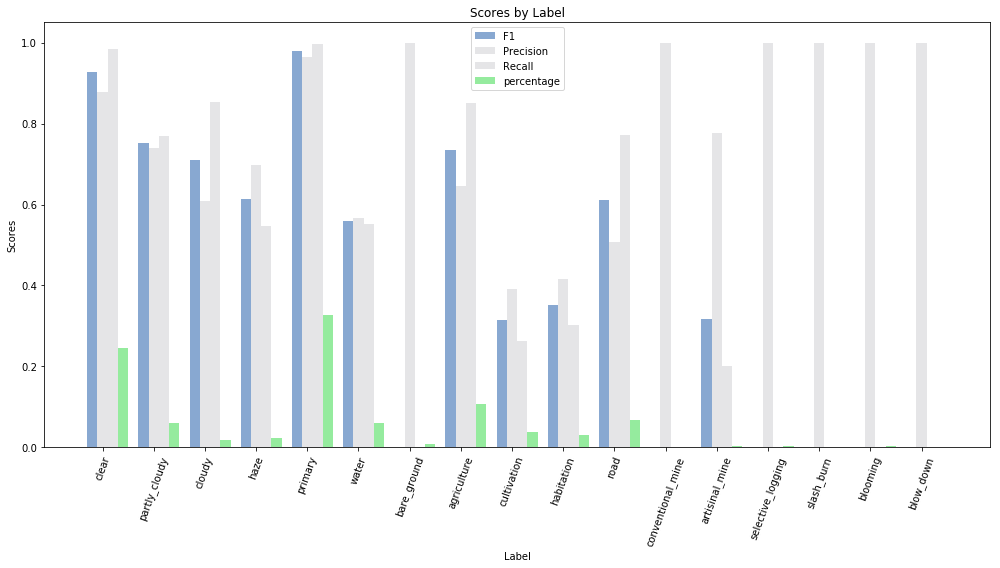

In [12]:
plt.rcParams['figure.figsize'] = (14, 8)
fig, ax = plt.subplots()
index = np.arange(len(labels))
bar_width = 0.20
opacity = 0.8

rects1 = plt.bar(index, f1, bar_width,
                 alpha=opacity,
                 color='#6A93C6',
                 label='F1')
 
rects2 = plt.bar(index + bar_width, precision, bar_width,
                 alpha=opacity,
                 color='#DFDFE2',
                 label='Precision')
 
rects3 = plt.bar(index + bar_width + bar_width, recall, bar_width,
                 alpha=opacity,
                 color='#DFDFE2',
                 label='Recall')

rects4 = plt.bar(index + bar_width + bar_width + bar_width, labelPercentage, bar_width,
                 alpha=opacity,
                 color='#7BE686',
                 label='percentage')
 
plt.xlabel('Label')
plt.ylabel('Scores')
plt.title('Scores by Label')
plt.xticks(rotation=70)
plt.xticks(index + bar_width, (label for label in labels))
plt.legend()
 
plt.tight_layout()
plt.show()

# Labels 
# ['selective_logging', 'conventional_mine', 'partly_cloudy',
#        'artisinal_mine', 'haze', 'slash_burn', 'primary', 'clear',
#        'bare_ground', 'blooming', 'water', 'road', 'cloudy', 'habitation',
#        'agriculture', 'blow_down', 'cultivation']

# Training set label distribution
# {'slash_burn': 209.0, 'blooming': 332.0, 'water': 7262.0, 'cloudy': 2330.0, 'selective_logging': 340.0,
#  'road': 8076.0, 'primary': 37840.0, 'clear': 28203.0, 'haze': 2695.0, 'agriculture': 12338.0, 'cultivation': 4477.0, 
#  'partly_cloudy': 7251.0, 'bare_ground': 859.0, 'conventional_mine': 100.0, 'artisinal_mine': 339.0, 
#  'habitation': 3662.0, 'blow_down': 98.0}

In [ ]:
##### SUBMISSION RUN #####
# Making Final Predictions using all training data
print('Fitting model')
model.fit(X, y, batch_size=32, nb_epoch=1,callbacks=[check],validation_data=(test_dataset,test_labels))

In [13]:
print('Making submission predictions')
rerun = True

saveImgEdgePathSubmission = folderpath+'pickleImgEdgeSubmission'
saveImgLinePathSubmission = folderpath+'pickleImgLineSubmission'
saveImgCornerPathSubmission = folderpath+'pickleImgCornerSubmission'
saveImgStatsPathSubmission = folderpath+'pickleImgStatsSubmission'
saveSubmissionImgRawPath = folderpath+'pickleImgRawSubmission'

if rerun == True or not os.path.isfile(saveImgRawPath):

    submission_ImgEdge = getEdges(test, test_path)
    submission_ImgLine = getLines(test, test_path)
    submission_ImgCorner = getCorners(test, test_path)
    submission_ImgStats = extract_features(test, test_path)
    submission_ImgRaw = get_raw(test, test_path)

    pickle.dump(submission_ImgEdge, open( saveImgEdgePathSubmission , 'wb'))
    pickle.dump(submission_ImgLine, open( saveImgLinePathSubmission , 'wb'))
    pickle.dump(submission_ImgCorner, open( saveImgCornerPathSubmission , 'wb'))
    pickle.dump(submission_ImgStats, open( saveImgStatsPathSubmission , 'wb'))
    pickle.dump(submission_ImgRaw, open( saveSubmissionImgRawPath , 'wb'))

else:

    submission_ImgEdge = pickle.load(open(saveImgEdgePathSubmission, 'rb'))
    submission_ImgLine = pickle.load(open(saveImgLinePathSubmission, 'rb'))
    submission_ImgCorner = pickle.load(open(saveImgCornerPathSubmission, 'rb'))
    submission_ImgStats = pickle.load(open(saveImgStatsPathSubmission, 'rb'))
    submission_ImgRaw = pickle.load(open(saveSubmissionImgRawPath, 'rb'))
    

  0%|          | 0/61191 [00:00<?, ?it/s]

Making submission predictions
Setup Dataset


100%|██████████| 61191/61191 [01:27<00:00, 700.09it/s]


In [14]:
submission_dataset = shapingDataSet(submission_ImgRaw, submission_ImgEdge)

In [15]:
submission_predictions = model.predict(submission_dataset, batch_size=32, verbose=1)

61191/61191 [==============================] - 1174s     

In [32]:
submission_predictions_thresholded = np.copy(submission_predictions)
submission_predictions_thresholded[submission_predictions_thresholded < cutOff ] = 0
submission_predictions_thresholded[submission_predictions_thresholded > cutOff ] = 1

predictionLabels = [' '.join(labels[row > 0.2]) for row in submission_predictions_thresholded]

subm = pd.DataFrame()
subm['image_name'] = test.image_name.values
subm['tags'] = predictionLabels
subm.to_csv(folderpath+'submission.csv', index=False)